In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.style as style

import numpy as np
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import time, datetime
import os
import random

## Pre-defined Functions

### Show Image

In [2]:
def imshow(img):
    style.use('classic')
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Show and Save Figure

In [3]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    style.use('ggplot')
    
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./loss.png')

In [4]:
def save_plots_comparison(train_acc, valid_acc, mlp_valid_acc, train_loss, valid_loss, mlp_valid_loss):
    
    style.use('ggplot')
    
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.plot(
        mlp_valid_acc, color='red', linestyle='-', 
        label='MLP validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./accuracy_comparison.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='green', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='blue', linestyle='-', 
        label='validataion loss'
    )
    plt.plot(
        mlp_valid_loss, color='red', linestyle='-', 
        label='MLP validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./loss_comparison.png')

### Saving Model

In [5]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './model.pth')

### Train and Validation Functions

In [6]:
# Train
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

## Networks

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 7)
        self.conv2 = torch.nn.Conv2d(32, 64, 7)
        self.conv3 = torch.nn.Conv2d(64, 128, 5)
        self.conv4 = torch.nn.Conv2d(128, 256, 7)
        
        self.fc1 = torch.nn.Linear(256, 32)
        self.fc2 = torch.nn.Linear(32, 3)
        
        self.pool = torch.nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.dropout2d(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
class MLP(torch.nn.Module):  
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(300 * 300 * 3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.layers(x)


## Load Data

In [9]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
trainset = datasets.ImageFolder('./traindata', transform=train_transform)
trainset_ex = datasets.ImageFolder('./traindataextra', transform=train_transform)

validset = datasets.ImageFolder('./validdata', transform=valid_transform)

classes = ('cherry', 'strawberry', 'tomato')

## EDA and Pre-processing

In [25]:
print('Initial Train Data')
for direc in os.listdir('./traindata'):
    if direc == '.DS_Store':
        continue
    ims = os.listdir('./traindata/' + direc)
    ims = np.array(ims)
    ims = np.where(ims != '.DS_Store')
    ims = list(ims)
    print(direc, ':',len(ims[0])) # use[0] because np.where returns tuple

Initial Train Data
cherry : 1036
strawberry : 1036
tomato : 1036


In [11]:
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(999)

In [13]:
# trainSet, validSet = torch.utils.data.random_split(dataset, [3126, 1340], generator=torch.Generator().manual_seed(42))

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True ,num_workers=4, generator=g, pin_memory=True)
trainLoader_ex = torch.utils.data.DataLoader(trainset_ex, batch_size=batch_size,
                                          shuffle=True, drop_last=True ,num_workers=4, generator=g, pin_memory=True)
validationLoader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, drop_last=True, num_workers=4, generator=g, pin_memory=True)

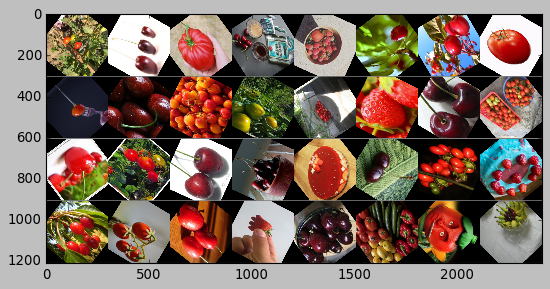

tomato cherry tomato cherry strawberry cherry cherry tomato tomato cherry cherry tomato cherry strawberry cherry tomato cherry tomato cherry cherry strawberry cherry tomato strawberry cherry tomato cherry strawberry cherry tomato tomato cherry


In [14]:
trainiter = iter(trainLoader)
images, labels = trainiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Training Loop

### MLP Base Line

In [18]:
epochs = 40
learningRate = 0.001
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
mlp = MLP().to(device)
lossFn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learningRate)
print(f"Computation device: {device}\n")

Computation device: cuda



[INFO]: Epoch 1 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 4.512, training acc: 39.350
Validation loss: 2.913, validation acc: 37.613
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.178, training acc: 37.098
Validation loss: 2.702, validation acc: 30.931
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.098, training acc: 34.395
Validation loss: 2.727, validation acc: 31.532
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.098, training acc: 34.781
Validation loss: 2.876, validation acc: 30.856
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.103, training acc: 35.232
Validation loss: 2.814, validation acc: 34.459
--------------------------------------------------
[INFO]: Epoch 6 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.096, training acc: 34.781
Validation loss: 2.814, validation acc: 31.156
--------------------------------------------------
[INFO]: Epoch 7 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.094, training acc: 36.229
Validation loss: 2.849, validation acc: 35.435
--------------------------------------------------
[INFO]: Epoch 8 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.092, training acc: 35.264
Validation loss: 2.855, validation acc: 34.009
--------------------------------------------------
[INFO]: Epoch 9 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.091, training acc: 38.642
Validation loss: 2.902, validation acc: 32.207
--------------------------------------------------
[INFO]: Epoch 10 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.087, training acc: 39.607
Validation loss: 2.904, validation acc: 39.940
--------------------------------------------------
[INFO]: Epoch 11 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.062, training acc: 44.498
Validation loss: 3.034, validation acc: 39.264
--------------------------------------------------
[INFO]: Epoch 12 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.061, training acc: 42.214
Validation loss: 1.944, validation acc: 40.090
--------------------------------------------------
[INFO]: Epoch 13 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.052, training acc: 44.015
Validation loss: 2.007, validation acc: 38.664
--------------------------------------------------
[INFO]: Epoch 14 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.062, training acc: 41.634
Validation loss: 1.917, validation acc: 38.438
--------------------------------------------------
[INFO]: Epoch 15 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.040, training acc: 44.402
Validation loss: 1.959, validation acc: 41.667
--------------------------------------------------
[INFO]: Epoch 16 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.041, training acc: 46.686
Validation loss: 1.878, validation acc: 33.934
--------------------------------------------------
[INFO]: Epoch 17 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.030, training acc: 47.297
Validation loss: 1.824, validation acc: 39.940
--------------------------------------------------
[INFO]: Epoch 18 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.022, training acc: 46.622
Validation loss: 2.007, validation acc: 41.817
--------------------------------------------------
[INFO]: Epoch 19 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.020, training acc: 48.906
Validation loss: 1.764, validation acc: 41.366
--------------------------------------------------
[INFO]: Epoch 20 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.021, training acc: 47.876
Validation loss: 1.953, validation acc: 39.264
--------------------------------------------------
[INFO]: Epoch 21 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.005, training acc: 49.743
Validation loss: 1.801, validation acc: 41.441
--------------------------------------------------
[INFO]: Epoch 22 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.013, training acc: 48.198
Validation loss: 1.777, validation acc: 38.889
--------------------------------------------------
[INFO]: Epoch 23 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.009, training acc: 49.517
Validation loss: 1.773, validation acc: 40.315
--------------------------------------------------
[INFO]: Epoch 24 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.999, training acc: 49.356
Validation loss: 1.718, validation acc: 39.940
--------------------------------------------------
[INFO]: Epoch 25 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.983, training acc: 52.027
Validation loss: 1.664, validation acc: 41.366
--------------------------------------------------
[INFO]: Epoch 26 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.984, training acc: 51.416
Validation loss: 1.672, validation acc: 39.114
--------------------------------------------------
[INFO]: Epoch 27 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.986, training acc: 49.743
Validation loss: 1.725, validation acc: 41.441
--------------------------------------------------
[INFO]: Epoch 28 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.970, training acc: 53.057
Validation loss: 1.782, validation acc: 42.943
--------------------------------------------------
[INFO]: Epoch 29 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.971, training acc: 51.931
Validation loss: 1.853, validation acc: 39.640
--------------------------------------------------
[INFO]: Epoch 30 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.981, training acc: 51.577
Validation loss: 1.602, validation acc: 41.517
--------------------------------------------------
[INFO]: Epoch 31 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.978, training acc: 52.574
Validation loss: 1.602, validation acc: 44.219
--------------------------------------------------
[INFO]: Epoch 32 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.988, training acc: 51.898
Validation loss: 1.585, validation acc: 42.718
--------------------------------------------------
[INFO]: Epoch 33 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.971, training acc: 52.638
Validation loss: 1.701, validation acc: 41.141
--------------------------------------------------
[INFO]: Epoch 34 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.969, training acc: 53.539
Validation loss: 1.682, validation acc: 43.318
--------------------------------------------------
[INFO]: Epoch 35 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.959, training acc: 53.024
Validation loss: 1.684, validation acc: 40.691
--------------------------------------------------
[INFO]: Epoch 36 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.970, training acc: 54.215
Validation loss: 1.594, validation acc: 44.595
--------------------------------------------------
[INFO]: Epoch 37 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.951, training acc: 54.376
Validation loss: 1.646, validation acc: 45.120
--------------------------------------------------
[INFO]: Epoch 38 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.949, training acc: 53.990
Validation loss: 1.602, validation acc: 41.066
--------------------------------------------------
[INFO]: Epoch 39 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.956, training acc: 53.700
Validation loss: 1.687, validation acc: 40.841
--------------------------------------------------
[INFO]: Epoch 40 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.956, training acc: 54.665
Validation loss: 1.730, validation acc: 43.393
--------------------------------------------------
Time taken: 555.54384
TRAINING COMPLETE


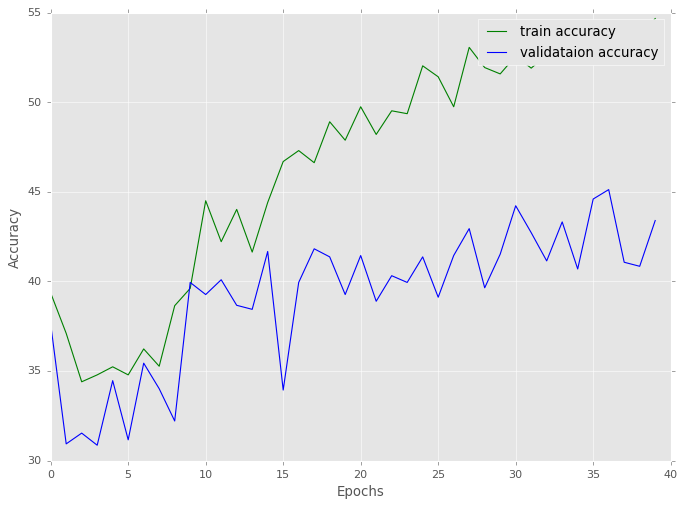

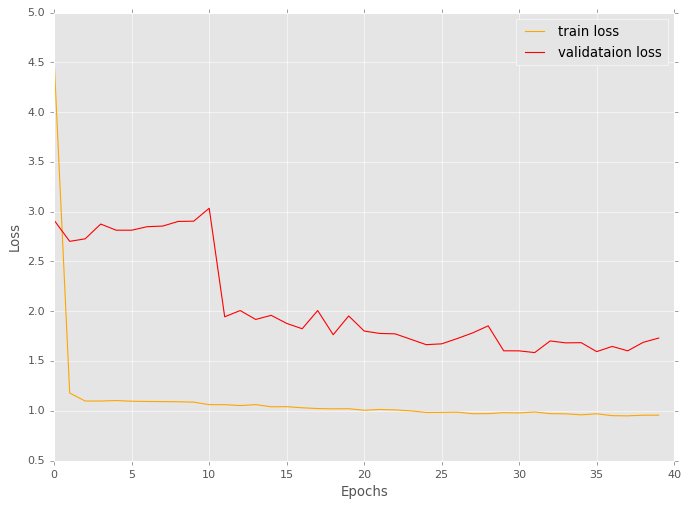

In [20]:
# lists to keep track of losses and accuracies
mlp_train_loss, mlp_valid_loss = [], []
mlp_train_acc, mlp_valid_acc = [], []

# start the training
start_time = datetime.datetime.now()
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(mlp, trainLoader, 
                                              optimizer, lossFn)
    valid_epoch_loss, valid_epoch_acc = validate(mlp, validationLoader,  
                                                 lossFn)
    mlp_train_loss.append(train_epoch_loss)
    mlp_valid_loss.append(valid_epoch_loss)
    mlp_train_acc.append(train_epoch_acc)
    mlp_valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    
end_time = datetime.datetime.now()
exe_time = (end_time-start_time).total_seconds()
print('Time taken: {}'.format(exe_time))

# save the trained model weights
# save_model(epochs, mlp, optimizer, lossFn)
# save the loss and accuracy plots
save_plots(mlp_train_acc, mlp_valid_acc, mlp_train_loss, mlp_valid_loss)
print('TRAINING COMPLETE')

### CNN Model

In [21]:
epochs = 40
learningRate = 0.0005
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
cnn = CNN().to(device)
lossFn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learningRate)
print(f"Computation device: {device}\n")

Computation device: cuda



In [23]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

[INFO]: Epoch 1 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.092, training acc: 36.454
Validation loss: 1.076, validation acc: 43.769
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.059, training acc: 43.050
Validation loss: 1.084, validation acc: 39.039
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.036, training acc: 47.040
Validation loss: 1.044, validation acc: 44.895
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.998, training acc: 50.064
Validation loss: 1.141, validation acc: 41.066
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.988, training acc: 50.837
Validation loss: 1.021, validation acc: 50.300
--------------------------------------------------
[INFO]: Epoch 6 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.967, training acc: 53.925
Validation loss: 0.994, validation acc: 50.450
--------------------------------------------------
[INFO]: Epoch 7 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.931, training acc: 57.014
Validation loss: 0.986, validation acc: 51.727
--------------------------------------------------
[INFO]: Epoch 8 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.915, training acc: 57.561
Validation loss: 1.000, validation acc: 52.628
--------------------------------------------------
[INFO]: Epoch 9 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.900, training acc: 59.620
Validation loss: 0.939, validation acc: 55.931
--------------------------------------------------
[INFO]: Epoch 10 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.888, training acc: 60.875
Validation loss: 0.916, validation acc: 56.832
--------------------------------------------------
[INFO]: Epoch 11 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.834, training acc: 64.125
Validation loss: 0.857, validation acc: 60.961
--------------------------------------------------
[INFO]: Epoch 12 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.820, training acc: 63.417
Validation loss: 0.877, validation acc: 60.210
--------------------------------------------------
[INFO]: Epoch 13 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.766, training acc: 68.436
Validation loss: 0.811, validation acc: 64.940
--------------------------------------------------
[INFO]: Epoch 14 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.728, training acc: 70.721
Validation loss: 0.764, validation acc: 68.844
--------------------------------------------------
[INFO]: Epoch 15 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.711, training acc: 71.332
Validation loss: 0.808, validation acc: 64.790
--------------------------------------------------
[INFO]: Epoch 16 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.669, training acc: 73.230
Validation loss: 0.763, validation acc: 67.042
--------------------------------------------------
[INFO]: Epoch 17 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.639, training acc: 73.488
Validation loss: 0.734, validation acc: 70.796
--------------------------------------------------
[INFO]: Epoch 18 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.601, training acc: 75.997
Validation loss: 0.740, validation acc: 71.171
--------------------------------------------------
[INFO]: Epoch 19 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.609, training acc: 75.997
Validation loss: 0.672, validation acc: 71.772
--------------------------------------------------
[INFO]: Epoch 20 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.582, training acc: 78.089
Validation loss: 0.658, validation acc: 72.147
--------------------------------------------------
[INFO]: Epoch 21 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 75.676
Validation loss: 0.691, validation acc: 71.396
--------------------------------------------------
[INFO]: Epoch 22 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.561, training acc: 77.381
Validation loss: 0.669, validation acc: 71.096
--------------------------------------------------
[INFO]: Epoch 23 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.517, training acc: 79.505
Validation loss: 0.677, validation acc: 73.348
--------------------------------------------------
[INFO]: Epoch 24 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.526, training acc: 79.440
Validation loss: 0.634, validation acc: 74.324
--------------------------------------------------
[INFO]: Epoch 25 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.510, training acc: 80.470
Validation loss: 0.689, validation acc: 72.823
--------------------------------------------------
[INFO]: Epoch 26 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.490, training acc: 81.885
Validation loss: 0.625, validation acc: 74.700
--------------------------------------------------
[INFO]: Epoch 27 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.488, training acc: 81.242
Validation loss: 0.666, validation acc: 75.676
--------------------------------------------------
[INFO]: Epoch 28 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.489, training acc: 81.499
Validation loss: 0.613, validation acc: 75.901
--------------------------------------------------
[INFO]: Epoch 29 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.497, training acc: 80.727
Validation loss: 0.648, validation acc: 73.574
--------------------------------------------------
[INFO]: Epoch 30 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.473, training acc: 81.821
Validation loss: 0.660, validation acc: 74.174
--------------------------------------------------
[INFO]: Epoch 31 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.469, training acc: 80.952
Validation loss: 0.599, validation acc: 76.051
--------------------------------------------------
[INFO]: Epoch 32 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.454, training acc: 81.757
Validation loss: 0.634, validation acc: 75.826
--------------------------------------------------
[INFO]: Epoch 33 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.444, training acc: 82.754
Validation loss: 0.624, validation acc: 75.300
--------------------------------------------------
[INFO]: Epoch 34 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.450, training acc: 83.172
Validation loss: 0.586, validation acc: 77.027
--------------------------------------------------
[INFO]: Epoch 35 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.416, training acc: 83.301
Validation loss: 0.642, validation acc: 75.450
--------------------------------------------------
[INFO]: Epoch 36 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.453, training acc: 82.079
Validation loss: 0.591, validation acc: 77.778
--------------------------------------------------
[INFO]: Epoch 37 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.411, training acc: 83.880
Validation loss: 0.677, validation acc: 75.526
--------------------------------------------------
[INFO]: Epoch 38 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.427, training acc: 83.687
Validation loss: 0.642, validation acc: 75.526
--------------------------------------------------
[INFO]: Epoch 39 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.415, training acc: 84.299
Validation loss: 0.619, validation acc: 76.351
--------------------------------------------------
[INFO]: Epoch 40 of 40
Training


  0%|          | 0/97 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.362, training acc: 86.390
Validation loss: 0.550, validation acc: 78.378
--------------------------------------------------
Time taken: 1111.275134
TRAINING COMPLETE


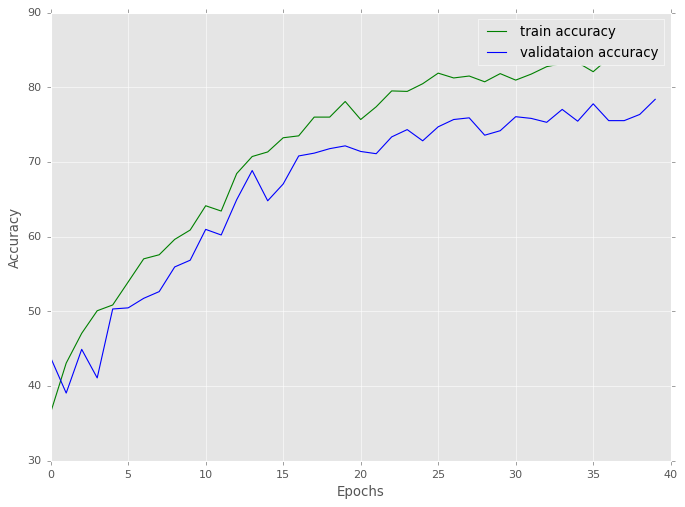

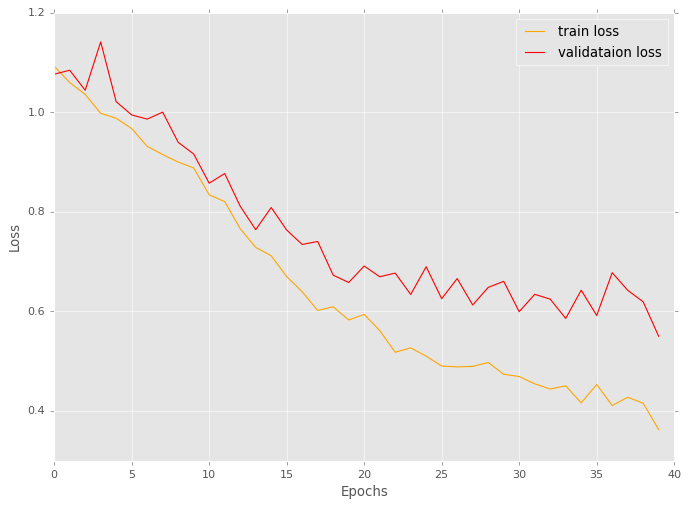

In [24]:
# start the training
start_time = datetime.datetime.now()
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(cnn, trainLoader, 
                                              optimizer, lossFn)
    valid_epoch_loss, valid_epoch_acc = validate(cnn, validationLoader,  
                                                 lossFn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

end_time = datetime.datetime.now()
exe_time = (end_time-start_time).total_seconds()
print('Time taken: {}'.format(exe_time))
    
# save the trained model weights
save_model(epochs, cnn, optimizer, lossFn)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

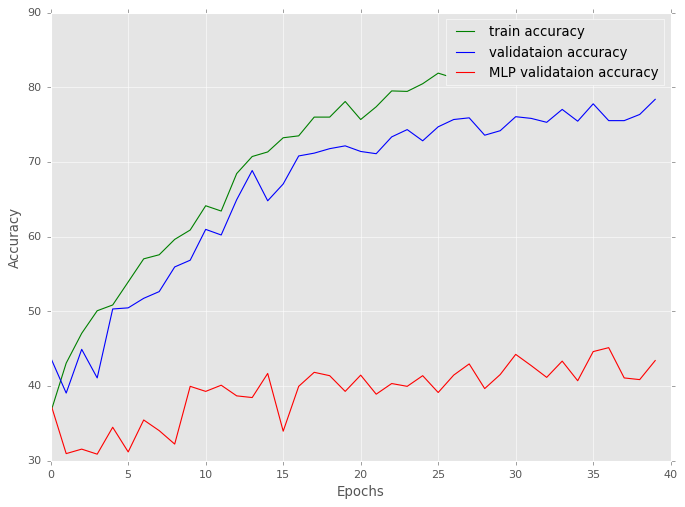

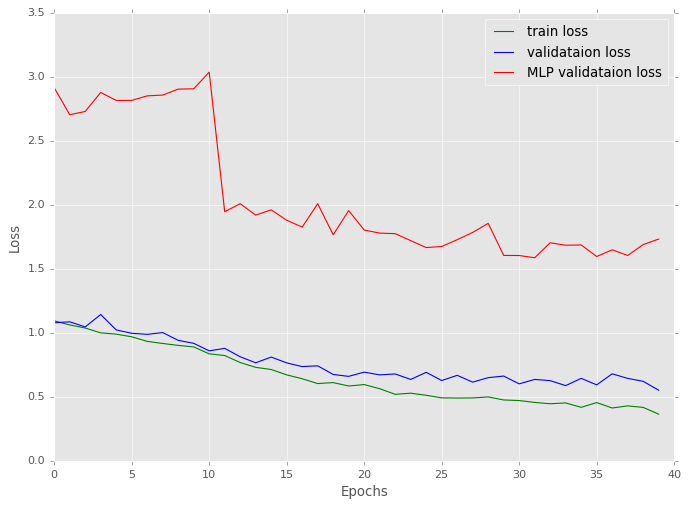

In [25]:
save_plots_comparison(train_acc, valid_acc, mlp_valid_acc, train_loss, valid_loss, mlp_valid_loss)

### Additional Data

In [46]:
epochs = 40
learningRate = 0.0005
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
cnn_ex = CNN().to(device)
lossFn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_ex.parameters(), lr=learningRate)
print(f"Computation device: {device}\n")

Computation device: cuda



In [48]:
# lists to keep track of losses and accuracies
train_ex_loss, valid_ex_loss = [], []
train_ex_acc, valid_ex_acc = [], []

In [49]:
# start the training
start_time = datetime.datetime.now()
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(cnn_ex, trainLoader_ex, 
                                              optimizer, lossFn)
    valid_epoch_loss, valid_epoch_acc = validate(cnn_ex, validationLoader,  
                                                 lossFn)
    train_ex_loss.append(train_epoch_loss)
    valid_ex_loss.append(valid_epoch_loss)
    train_ex_acc.append(train_epoch_acc)
    valid_ex_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

end_time = datetime.datetime.now()
exe_time = (end_time-start_time).total_seconds()
print('Time taken: {}'.format(exe_time))
    
# save the trained model weights
save_model(epochs, cnn_ex, optimizer, lossFn)
# save the loss and accuracy plots
save_plots(train_ex_acc, valid_ex_acc, train_ex_loss, valid_ex_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 1.062, training acc: 45.092
Validation loss: 1.054, validation acc: 43.168
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.983, training acc: 51.321
Validation loss: 0.989, validation acc: 50.150
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.953, training acc: 55.070
Validation loss: 0.983, validation acc: 52.628
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.927, training acc: 56.041
Validation loss: 0.965, validation acc: 52.327
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.907, training acc: 57.416
Validation loss: 0.957, validation acc: 54.354
--------------------------------------------------
[INFO]: Epoch 6 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.908, training acc: 58.738
Validation loss: 0.947, validation acc: 53.303
--------------------------------------------------
[INFO]: Epoch 7 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.884, training acc: 59.628
Validation loss: 1.024, validation acc: 52.327
--------------------------------------------------
[INFO]: Epoch 8 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.881, training acc: 59.951
Validation loss: 0.903, validation acc: 59.084
--------------------------------------------------
[INFO]: Epoch 9 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.827, training acc: 63.053
Validation loss: 0.882, validation acc: 61.637
--------------------------------------------------
[INFO]: Epoch 10 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.795, training acc: 66.262
Validation loss: 0.803, validation acc: 65.691
--------------------------------------------------
[INFO]: Epoch 11 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.723, training acc: 70.604
Validation loss: 0.766, validation acc: 68.544
--------------------------------------------------
[INFO]: Epoch 12 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.712, training acc: 71.548
Validation loss: 0.759, validation acc: 68.093
--------------------------------------------------
[INFO]: Epoch 13 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.671, training acc: 73.220
Validation loss: 0.737, validation acc: 69.444
--------------------------------------------------
[INFO]: Epoch 14 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.622, training acc: 74.838
Validation loss: 0.661, validation acc: 73.273
--------------------------------------------------
[INFO]: Epoch 15 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.575, training acc: 77.077
Validation loss: 0.661, validation acc: 72.673
--------------------------------------------------
[INFO]: Epoch 16 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.555, training acc: 77.373
Validation loss: 0.698, validation acc: 70.796
--------------------------------------------------
[INFO]: Epoch 17 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.531, training acc: 78.749
Validation loss: 0.595, validation acc: 76.877
--------------------------------------------------
[INFO]: Epoch 18 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.523, training acc: 79.612
Validation loss: 0.646, validation acc: 72.297
--------------------------------------------------
[INFO]: Epoch 19 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.485, training acc: 81.068
Validation loss: 0.705, validation acc: 70.120
--------------------------------------------------
[INFO]: Epoch 20 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.485, training acc: 80.609
Validation loss: 0.595, validation acc: 75.676
--------------------------------------------------
[INFO]: Epoch 21 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.466, training acc: 81.661
Validation loss: 0.596, validation acc: 76.276
--------------------------------------------------
[INFO]: Epoch 22 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.479, training acc: 81.041
Validation loss: 0.654, validation acc: 72.823
--------------------------------------------------
[INFO]: Epoch 23 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.461, training acc: 81.041
Validation loss: 0.578, validation acc: 76.652
--------------------------------------------------
[INFO]: Epoch 24 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.454, training acc: 81.688
Validation loss: 0.587, validation acc: 77.027
--------------------------------------------------
[INFO]: Epoch 25 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.442, training acc: 82.605
Validation loss: 0.558, validation acc: 78.003
--------------------------------------------------
[INFO]: Epoch 26 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.435, training acc: 82.228
Validation loss: 0.545, validation acc: 78.453
--------------------------------------------------
[INFO]: Epoch 27 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.403, training acc: 83.873
Validation loss: 0.626, validation acc: 75.826
--------------------------------------------------
[INFO]: Epoch 28 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.407, training acc: 83.495
Validation loss: 0.595, validation acc: 76.351
--------------------------------------------------
[INFO]: Epoch 29 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.399, training acc: 83.765
Validation loss: 0.606, validation acc: 76.727
--------------------------------------------------
[INFO]: Epoch 30 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.416, training acc: 83.064
Validation loss: 0.651, validation acc: 74.024
--------------------------------------------------
[INFO]: Epoch 31 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.403, training acc: 83.792
Validation loss: 0.556, validation acc: 77.252
--------------------------------------------------
[INFO]: Epoch 32 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.394, training acc: 84.412
Validation loss: 0.641, validation acc: 76.652
--------------------------------------------------
[INFO]: Epoch 33 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.384, training acc: 84.574
Validation loss: 0.537, validation acc: 77.778
--------------------------------------------------
[INFO]: Epoch 34 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.386, training acc: 83.846
Validation loss: 0.584, validation acc: 76.502
--------------------------------------------------
[INFO]: Epoch 35 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.348, training acc: 85.545
Validation loss: 0.526, validation acc: 78.754
--------------------------------------------------
[INFO]: Epoch 36 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.370, training acc: 84.790
Validation loss: 0.508, validation acc: 79.354
--------------------------------------------------
[INFO]: Epoch 37 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.355, training acc: 85.814
Validation loss: 0.551, validation acc: 78.979
--------------------------------------------------
[INFO]: Epoch 38 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.339, training acc: 85.895
Validation loss: 0.592, validation acc: 76.652
--------------------------------------------------
[INFO]: Epoch 39 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.337, training acc: 86.354
Validation loss: 0.588, validation acc: 78.378
--------------------------------------------------
[INFO]: Epoch 40 of 40
Training


  0%|          | 0/115 [00:00<?, ?it/s]

Validation


  0%|          | 0/41 [00:00<?, ?it/s]

Training loss: 0.314, training acc: 87.406
Validation loss: 0.494, validation acc: 80.480
--------------------------------------------------
Time taken: 1268.43415


NameError: name 'rain_ex_acc' is not defined

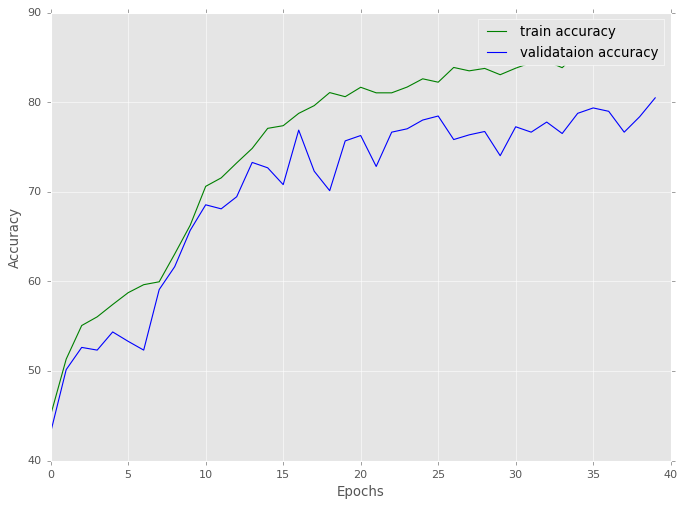

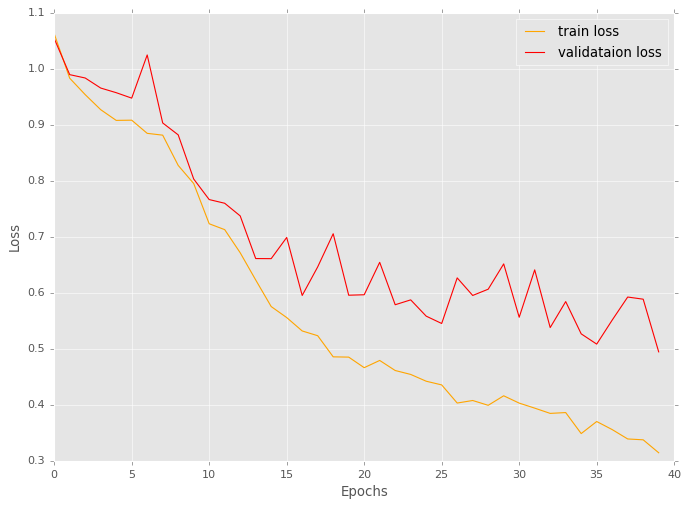

In [50]:
save_plots(train_ex_acc, valid_ex_acc, train_ex_loss, valid_ex_loss)